In [8]:
from walidacja_funkcji import *
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import wasserstein_distance

In [9]:
def reinit_model(model):
    """Reinicjalizuje wagi modelu"""
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

def fast_kl_jsd_2d(real_data, fake_data, bins=50):
    all_data = np.vstack([real_data, fake_data])
    range_2d = [(all_data[:, i].min(), all_data[:, i].max()) for i in range(all_data.shape[1])]
    
    # Histogramy w jednej operacji
    P, _ = np.histogramdd(real_data, bins=bins, range=range_2d, density=True)
    Q, _ = np.histogramdd(fake_data, bins=bins, range=range_2d, density=True)
    
    # Normalizacja do prawdopodobieństw
    P = P / P.sum()
    Q = Q / Q.sum()
    
    # Epsilon dla stabilności numerycznej
    epsilon = 1e-8
    P += epsilon
    Q += epsilon
    
    # KL divergence: KL(Q||P) - fake vs real
    kl_divergence = np.sum(Q * np.log(Q / P))
    
    # JSD: 0.5 * [KL(P||M) + KL(Q||M)], gdzie M = (P+Q)/2
    M = (P + Q) / 2 + epsilon
    
    kl_pm = np.sum(P * np.log(P / M))
    kl_qm = np.sum(Q * np.log(Q / M))
    jsd = 0.5 * (kl_pm + kl_qm)
    
    return kl_divergence, jsd

In [29]:
"""
    Generator z szumu bedzie dawac x i y - ale czy ja powinienem mu przeslac informacje o zakresie w jakim ma generowac x ?
"""

class Generator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5, BATCH_SIZE: int = 64, LATENT_DIM: int = 128, gamma: int = 0.9, step_size: int = 100):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.RMSprop(self.parameters(), lr)
        self.loss = nn.MSELoss()
        self.lr_scheduler = optim.lr_scheduler.StepLR(self.optim, step_size=step_size, gamma=gamma)
        self = self.to('cuda')
        var_x, var_y = 0, 0
        noise = torch.randn(size=(BATCH_SIZE, LATENT_DIM)).cuda()

        print('inicjalizacja wag')

        while var_x < 1e-3 or var_y < 1e-3:
            output = self.layers(noise).detach().cpu().numpy()
            var_x = np.var(output[:, 0])
            var_y = np.var(output[:, 1])
        
            for layer in self.modules():
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
        print(f'{var_x=}, {var_y=}')

In [11]:
"""
    Dyskriminator tak jak zwykle bierze input i zwraca czy prawdziwy czy nie
"""

class Discriminator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5, gamma: int = 0.9, step_size: int = 100):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.SGD(self.parameters(), lr)
        self.loss = nn.BCEWithLogitsLoss()
        self.lr_scheduler = optim.lr_scheduler.StepLR(self.optim, step_size=step_size, gamma=gamma)
        self = self.to('cuda')

    def training_step(self, true_data, fake_data, steps):
        for _ in range(steps):
            self.optim.zero_grad()
            y_true = self.layers(true_data)
            loss_true = self.loss(y_true, torch.ones_like(y_true).cuda())

            y_fake = self.layers(fake_data)
            loss_fake = self.loss(y_fake, torch.zeros_like(y_true).cuda())
            
            loss = loss_true + loss_fake
            loss.backward()
            loss = loss.detach().item()
            self.optim.step()
            self.lr_scheduler.step()
        
        return loss

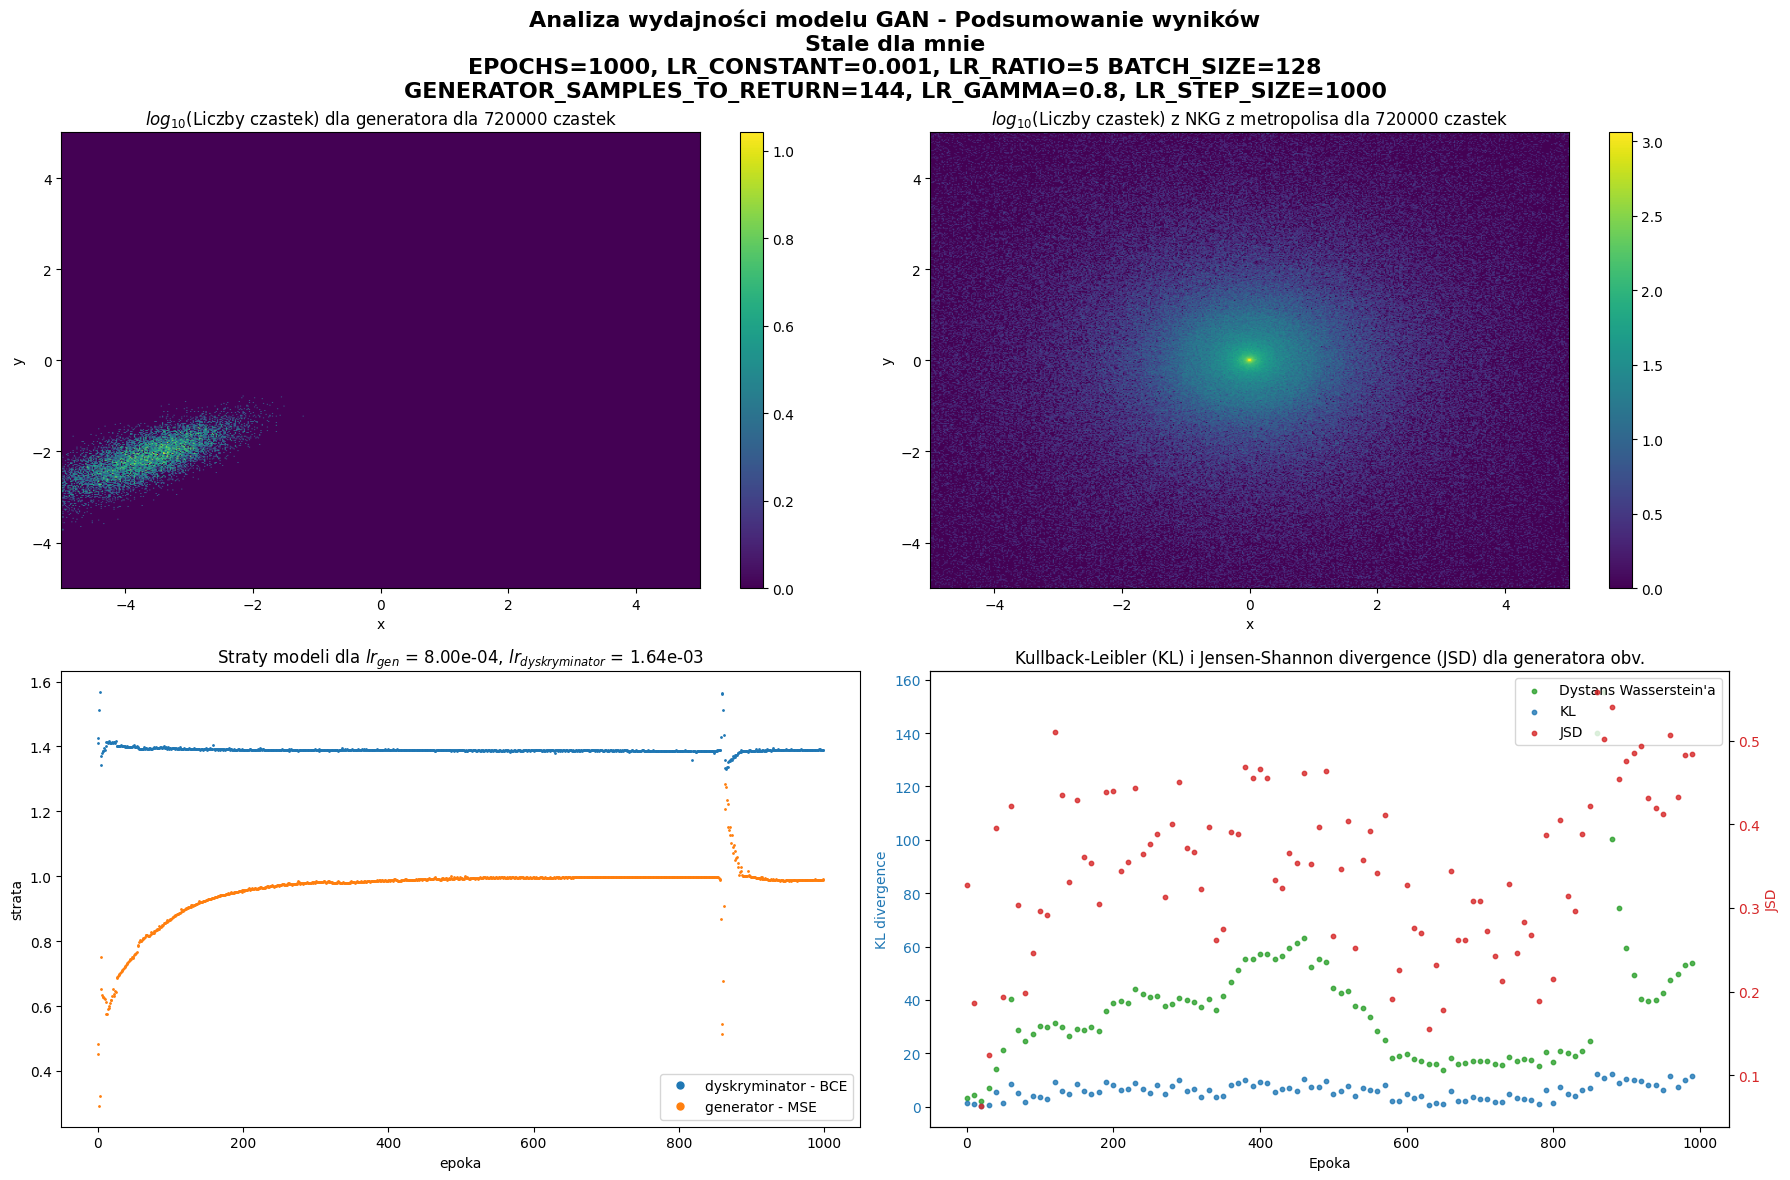

In [93]:
from matplotlib.colors import LogNorm

def get_2d_data(PROBE_SIZE: int):
    rs, _ = metropolis_hastings_probing(NKG, length=PROBE_SIZE // 2)
    theta = np.random.uniform(0, 2*np.pi, size=PROBE_SIZE // 2)
    xs = rs * np.cos(theta)
    ys = rs * np.sin(theta)
    return np.vstack([xs, ys])

def plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, EPOCHS_TO_SAVE_KL_JSD, LR_GAMMA, LR_STEP_SIZE, extra_label = ''):
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    SAMPLE_LENGTH = GENERATOR_SAMPLES_TO_RETURN * 10000
    ROI = np.array([[-5, 5], [-5, 5]])

    x_true, y_true = get_2d_data(SAMPLE_LENGTH)
    hist_true, x_true_edges, y_true_edges = np.histogram2d(x_true, y_true, bins=500, range=ROI)
    hist_true += 1

    noise = torch.randn(SAMPLE_LENGTH // GENERATOR_SAMPLES_TO_RETURN, LATENT_DIM).cuda()
    data = generator.layers(noise).detach().reshape(-1, 2).cpu().numpy()
    x_fake, y_fake = data.T
    hist_fake, x_fake_edges, y_fake_edges = np.histogram2d(x_fake, y_fake, bins=500, range=ROI)
    hist_fake += 1

    # Wykres 1: Hisogram z generatora
    ax1.set_title(rf'$log_{{10}}$(Liczby czastek) dla generatora dla {SAMPLE_LENGTH // 2} czastek')
    im = ax1.imshow(np.log10(hist_fake).T, extent=ROI.flatten(), aspect='auto')
    plt.colorbar(im, ax=ax1)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    # Wykres 2: Histogram danych prawdziwych 
    ax2.set_title(rf'$log_{{10}}$(Liczby czastek) z NKG z metropolisa dla {SAMPLE_LENGTH // 2} czastek')
    im = ax2.imshow(np.log10(hist_true).T, extent=ROI.flatten(), aspect='auto')
    plt.colorbar(im, ax=ax2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')

    # Wykres 3: Straty
    markersize = min(1000 / len(discriminator_losses), 10)
    ax3.set_title(rf'Straty modeli dla $lr_{{gen}}$ = {generator.optim.param_groups[0]["lr"]:.2e}, $lr_{{dyskryminator}}$ = {discriminator.optim.param_groups[0]["lr"]:.2e}')
    ax3.plot(discriminator_losses, 'o', markersize=markersize, label='dyskryminator - BCE')
    ax3.plot(generator_losses, 'o', markersize=markersize, label='generator - MSE')
    ax3.legend(markerscale=5 / markersize)
    ax3.set_xlabel('epoka')
    ax3.set_ylabel('strata')

    # Wykres 4: KL i JSD
    ax4.set_title('Kullback-Leibler (KL) i Jensen-Shannon divergence (JSD) dla generatora obv.')
    ax4.set_xlabel('Epoka')
    color1 = 'tab:blue'
    ax4.set_ylabel('KL divergence', color=color1)
    marker_size_kl = max(0.2, min(15, 1000 / len(KL)))
    marker_size_jsd = max(0.2, min(15, 1000 / len(JSD)))
    ax4.scatter(np.arange(KL.size) * EPOCHS_TO_SAVE_KL_JSD, Wasserstein_distance, s=marker_size_kl, color='tab:green', label='Dystans Wasserstein\'a', alpha=0.8)
    ax4.scatter(np.arange(KL.size) * EPOCHS_TO_SAVE_KL_JSD, KL, s=marker_size_kl,
                    color=color1, label='KL', alpha=0.8)
    ax4.tick_params(axis='y', labelcolor=color1)
    ax4_twin = ax4.twinx()
    color2 = 'tab:red'
    ax4_twin.set_ylabel('JSD', color=color2)
    ax4_twin.scatter(np.arange(JSD.size) * EPOCHS_TO_SAVE_KL_JSD, JSD, s=marker_size_jsd,
                        color=color2, label='JSD', alpha=0.8)
    ax4_twin.tick_params(axis='y', labelcolor=color2)
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right', markerscale=len(JSD)/100)

    plt.suptitle(f'Analiza wydajności modelu GAN - Podsumowanie wyników\nStale dla mnie\n{EPOCHS=}, {LR_CONSTANT=}, {LR_RATIO=} {BATCH_SIZE=}\n{GENERATOR_SAMPLES_TO_RETURN=}, {LR_GAMMA=}, {LR_STEP_SIZE=}' + extra_label, 
                fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.savefig(f'./Wykresy/Moj_NKG/podsumowanie{extra_label}.jpg')

plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, EPOCHS_TO_SAVE_KL_JSD, LR_GAMMA, LR_STEP_SIZE, '')

In [ ]:
# Konfiguracja
for LR_RATIO in [0.1, 0.5, 1, 5, 10, 50, 100, 500]:
    torch.manual_seed(42)
    np.random.seed(42)

    EPOCHS = 1_000
    LR_CONSTANT = 1e-3
    LR_STEP_SIZE = EPOCHS
    LR_GAMMA = 0.8
    # LR_RATIO = 5 # LR_DYSKR / LR_GEN
    BATCH_SIZE = 128
    LATENT_DIM = 128
    EPOCHS_TO_SAVE_KL_JSD = 10
    GENERATOR_SAMPLES_TO_RETURN = 144 # dla 1 na pewno dziala w miare gut

    generator_losses, discriminator_losses = np.zeros(EPOCHS), np.zeros(EPOCHS)
    KL, JSD, Wasserstein_distance = np.zeros(EPOCHS // EPOCHS_TO_SAVE_KL_JSD), np.zeros(EPOCHS // EPOCHS_TO_SAVE_KL_JSD), np.zeros(EPOCHS // EPOCHS_TO_SAVE_KL_JSD)

    generator_layers = [ # ale dla 2D to bedzie musialo byc super wolne
        nn.Linear(LATENT_DIM, 132),  nn.ReLU(),
        nn.Linear(132, 136),          nn.ReLU(),
        nn.Linear(136, 140),          nn.ReLU(),
        nn.Linear(140, 144),          nn.ReLU(),
        nn.Linear(144, GENERATOR_SAMPLES_TO_RETURN)
    ]
    generator = Generator(generator_layers, LR_CONSTANT, BATCH_SIZE, LATENT_DIM, LR_GAMMA, LR_STEP_SIZE)

    discriminator_layers = [ #! Nie dodawaj sigmoida on juz jest w funkcji straty
        nn.Linear(GENERATOR_SAMPLES_TO_RETURN, 128), nn.LeakyReLU(0.2),
        nn.Linear(128, 64), nn.LeakyReLU(0.2),
        nn.Linear(64, 32),  nn.LeakyReLU(0.2),
        nn.Linear(32, 16),  nn.LeakyReLU(0.2),
        nn.Linear(16, 8),   nn.LeakyReLU(0.2),
        nn.Linear(8, 2),    nn.LeakyReLU(0.2),
        nn.Linear(2, 1),
    ]
    discriminator = Discriminator(discriminator_layers, LR_CONSTANT * LR_RATIO, LR_GAMMA, LR_STEP_SIZE)

    generator.train()
    discriminator.train()

    epoch = 0
    while epoch < EPOCHS:
        noise = torch.randn(BATCH_SIZE, LATENT_DIM).cuda()
        fake_data = generator.layers(noise).detach()

        data = get_2d_data(BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN)
        true_data = torch.FloatTensor( data ).cuda().reshape(fake_data.shape)

        # Trening
        discriminator_losses[epoch] = discriminator.training_step(true_data, fake_data, 5)

        generator.zero_grad()
        fake_data = generator.layers(noise)
        fake_labels = discriminator.layers(fake_data)
        gen_loss = generator.loss(fake_labels, torch.ones_like(fake_labels))
        gen_loss.backward()
        gen_loss = gen_loss.detach().item()
        generator.optim.step()
        generator.lr_scheduler.step()
        generator_losses[epoch] = gen_loss

        if epoch % EPOCHS_TO_SAVE_KL_JSD == 0:
            true_data = true_data.reshape(-1, 1).cpu().detach().numpy()
            fake_data = fake_data.reshape(-1, 1).cpu().detach().numpy()
            progress = epoch / EPOCHS
            filled = int(200 * progress)
            bar = '█' * filled + '░' * (200 - filled)
            print(f'\rTrening [{bar}] {epoch:4d}/{EPOCHS} ({progress*100:5.1f}%)', end='', flush=True)

            KL[epoch // EPOCHS_TO_SAVE_KL_JSD], JSD[epoch // EPOCHS_TO_SAVE_KL_JSD] = fast_kl_jsd_2d(true_data, fake_data)
            Wasserstein_distance[epoch // EPOCHS_TO_SAVE_KL_JSD] = wasserstein_distance(fake_data.reshape(-1,), true_data.reshape(-1,))

        epoch += 1

    bar = '█' * 200
    print(f'\rTrening [{bar}] {epoch:4d}/{EPOCHS} ({100:5.1f}%)\n', end='', flush=True)

    plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, EPOCHS_TO_SAVE_KL_JSD, LR_GAMMA, LR_STEP_SIZE, '')

inicjalizacja wag
var_x=np.float32(0.016248077), var_y=np.float32(0.016229933)
Trening [████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████] 1000/1000 (100.0%)
inicjalizacja wag
var_x=np.float32(0.016248077), var_y=np.float32(0.016229933)
Trening [████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████] 1000/1000 (100.0%)
inicjalizacja wag
var_x=np.float32(0.016248077), var_y=np.float32(0.016229933)
Trening [████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████] 1000/1000 (100.0%)


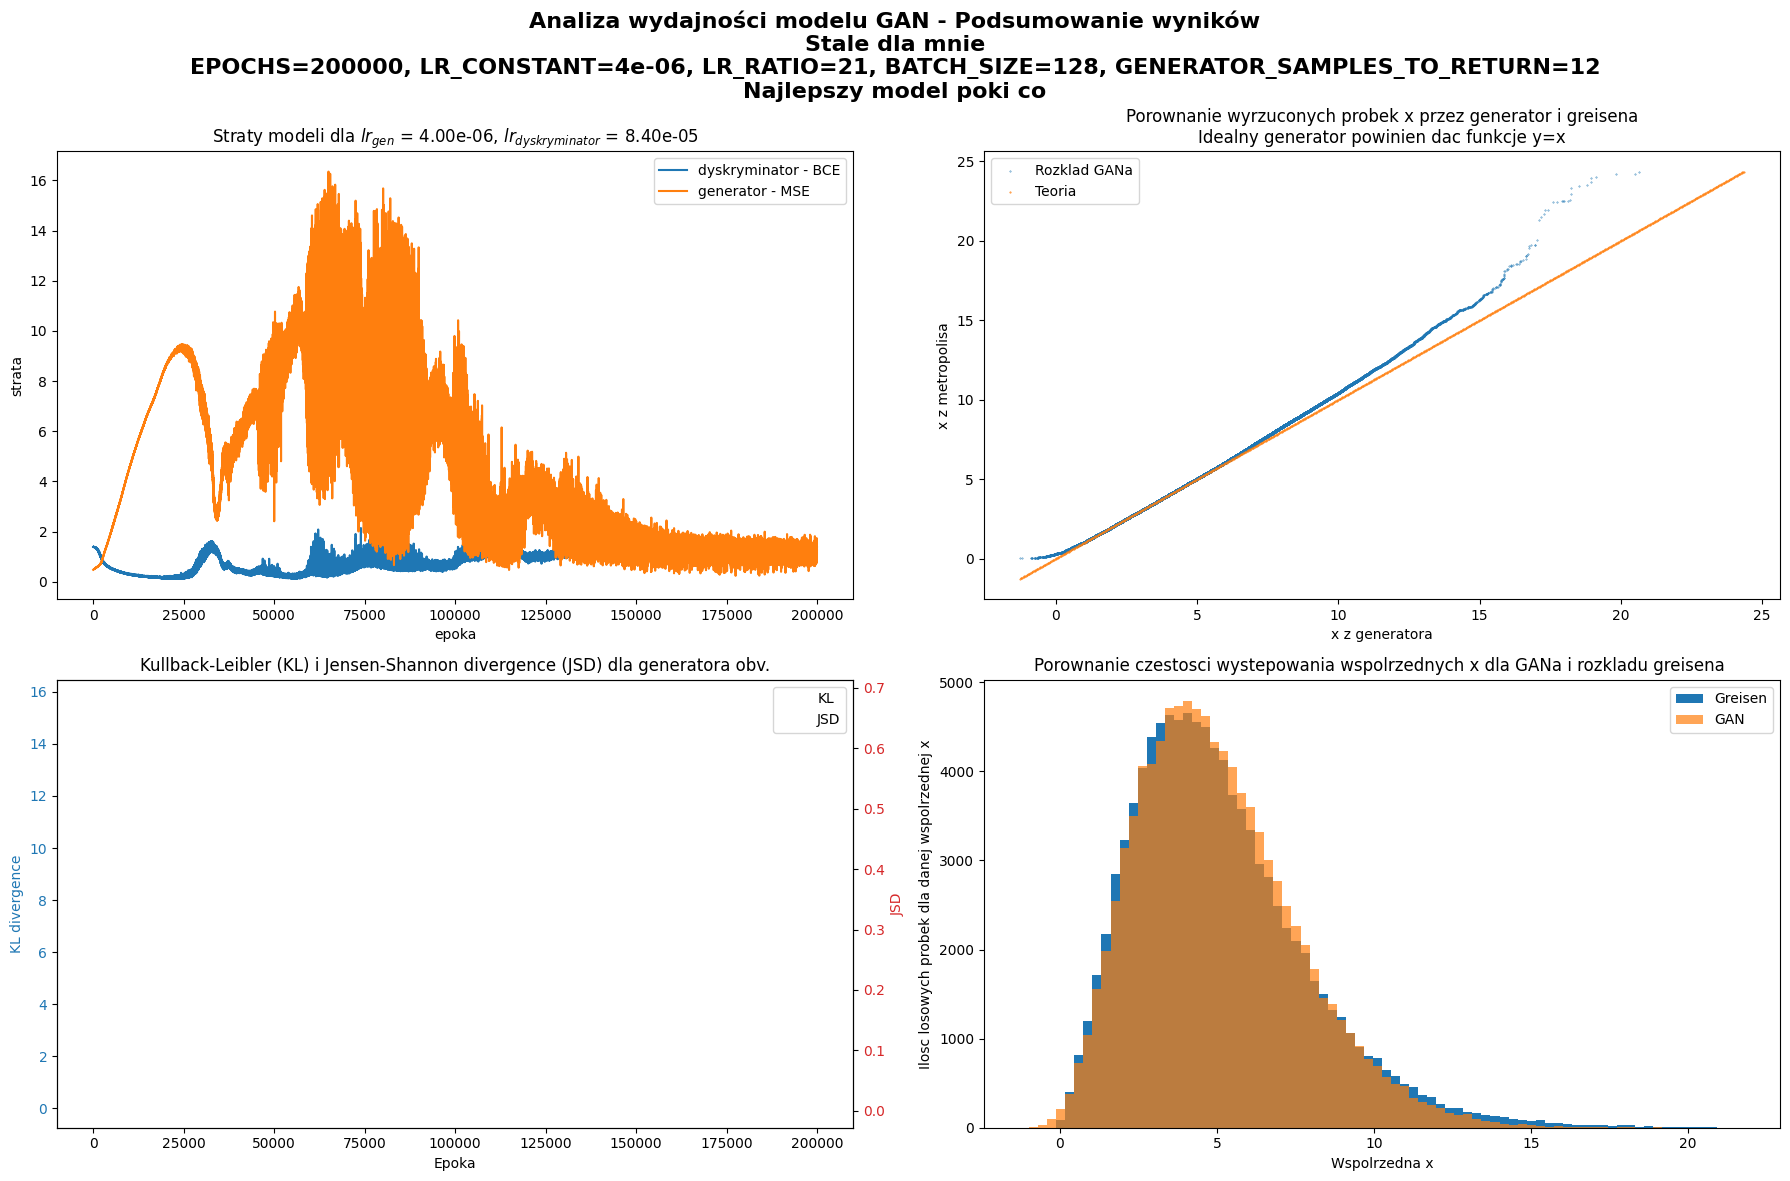

In [174]:
plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, EPOCHS_TO_SAVE_KL_JSD, '\nNajlepszy model poki co')
torch.save(discriminator.state_dict(), "best_discriminator_so_far.pth")
torch.save(generator.state_dict(), 'best_generator_so_far.pth')